# Lab 10

In this lab, you will:

* Implment a Model Predictive Control (MPC) application for the TCLab

# Exercise 1

There is an inherent weakness to feedback control: they rely only on feedback. In other words, they only take into account information from the present and the past when making control decisions.

Think about you as a control device: you constantly use predictions from the future to update your behavior. If you know there is a test coming up, you can increase the rate of your study. If instead you didn't take into account the test until the day of, it would be too late!

In terms of the TCLab, what if you knew that the setpoint was going to go up 10 seconds in the future? You could start the heater up earlier, insteady of waiting for the setpoint change to occur.

This is where MPC comes in. MPC uses model predictions to plan an optimized future trajectory.

A method to solve MPC (also known as dynamic control) problems is by numerically integrating the dynamic model at discrete time intervals, much like measuring a physical system at particular time points. The numerical solution is compared to a desired trajectory, and the difference is minimized by adjustable parameters in the model that may change at every time step. The first control action is taken and then the entire process is repeated at the next time instance. The process is repeated because objective targets may change or updated measurements may have adjusted parameter or state estimates.

MPC is a very complicated subject, and details are reserved for more advanced control courses. This lab is just meant to demonstrate that PID controllers aren't the endpoint of process control!

You are going to implement a MIMO control system for the Q1/T1 Q2/T2 system. Run the provided `MPC.py` script. The script implements several step changes in both T1 and T2. Observe the actual trajectories and predicted trajectories over time.

Calculate the IAE for the system.

Run the same experiment using your decoupled PID controller from Lab 9. Calculate the IAE for the system and compare to the results using the MPC controller.

### MPC Controller

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import json
# get gekko package with:
#   pip install gekko
from gekko import GEKKO
# get tclab package with:
#   pip install tclab
from tclab import TCLab

# Connect to Arduino
a = TCLab()

# Make an MP4 animation?
make_mp4 = False
if make_mp4:
    import imageio  # required to make animation
    import os
    try:
        os.mkdir('./figures')
    except:
        pass

# Final time
tf = 10 # min
# number of data points (every 3 seconds)
n = tf * 20 + 1

# Percent Heater (0-100%)
Q1s = np.zeros(n)
Q2s = np.zeros(n)

# Temperatures (degC)
T1m = a.T1 * np.ones(n)
T2m = a.T2 * np.ones(n)
# Temperature setpoints
T1sp = T1m[0] * np.ones(n)
T2sp = T2m[0] * np.ones(n)

# Heater set point steps about every 150 sec
T1sp[3:] = 40.0
T2sp[40:] = 30.0
T1sp[80:] = 32.0
T2sp[120:] = 35.0
T1sp[160:] = 45.0

#########################################################
# Initialize Model
#########################################################
# use remote=True for MacOS
m = GEKKO(name='tclab-mpc',remote=True)

# with a local server
#m = GEKKO(name='tclab-mpc',server='http://127.0.0.1',remote=True)

# Control horizon, non-uniform time steps
m.time = [0,3,6,10,14,18,22,27,32,38,45,55,65, \
          75,90,110,130,150]

# Parameters from Estimation
K1 = m.FV(value=0.607)
K2 = m.FV(value=0.293)
K3 = m.FV(value=0.24)
tau12 = m.FV(value=192)
tau3 = m.FV(value=15)

# don't update parameters with optimizer
K1.STATUS = 0
K2.STATUS = 0
K3.STATUS = 0
tau12.STATUS = 0
tau3.STATUS = 0

# Manipulated variables
Q1 = m.MV(value=0,name='q1')
Q1.STATUS = 1  # manipulated
Q1.FSTATUS = 0 # not measured
Q1.DMAX = 20.0
Q1.DCOST = 0.1
Q1.UPPER = 100.0
Q1.LOWER = 0.0

Q2 = m.MV(value=0,name='q2')
Q2.STATUS = 1  # manipulated
Q2.FSTATUS = 0 # not measured
Q2.DMAX = 30.0
Q2.DCOST = 0.1
Q2.UPPER = 100.0
Q2.LOWER = 0.0

# State variables
TH1 = m.SV(value=T1m[0])
TH2 = m.SV(value=T2m[0])

# Controlled variables
TC1 = m.CV(value=T1m[0],name='tc1')
TC1.STATUS = 1     # drive to set point
TC1.FSTATUS = 1    # receive measurement
TC1.TAU = 40       # response speed (time constant)
TC1.TR_INIT = 1    # reference trajectory
TC1.TR_OPEN = 0

TC2 = m.CV(value=T2m[0],name='tc2')
TC2.STATUS = 1     # drive to set point
TC2.FSTATUS = 1    # receive measurement
TC2.TAU = 0        # response speed (time constant)
TC2.TR_INIT = 0    # dead-band
TC2.TR_OPEN = 1

Ta = m.Param(value=23.0) # degC

# Heat transfer between two heaters
DT = m.Intermediate(TH2-TH1)

# Empirical correlations
m.Equation(tau12 * TH1.dt() + (TH1-Ta) == K1*Q1 + K3*DT)
m.Equation(tau12 * TH2.dt() + (TH2-Ta) == K2*Q2 - K3*DT)
m.Equation(tau3 * TC1.dt()  + TC1 == TH1)
m.Equation(tau3 * TC2.dt()  + TC2 == TH2)

# Global Options
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 3 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT
m.options.COLDSTART = 1 # COLDSTART on first cycle
##################################################################
# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
    for i in range(1,n-1):
        # Sleep time
        sleep_max = 3.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Celsius
        T1m[i] = a.T1
        T2m[i] = a.T2

        # Insert measurements
        TC1.MEAS = T1m[i]
        TC2.MEAS = T2m[i]

        # Adjust setpoints
        db1 = 1.0 # dead-band
        TC1.SPHI = T1sp[i] + db1
        TC1.SPLO = T1sp[i] - db1

        db2 = 0.2
        TC2.SPHI = T2sp[i] + db2
        TC2.SPLO = T2sp[i] - db2

        # Adjust heaters with MPC
        m.solve()

        if m.options.APPSTATUS == 1:
            # Retrieve new values
            Q1s[i+1]  = Q1.NEWVAL
            Q2s[i+1]  = Q2.NEWVAL
            # get additional solution information
            with open(m.path+'//results.json') as f:
                results = json.load(f)
        else:
            # Solution failed
            Q1s[i+1]  = 0.0
            Q2s[i+1]  = 0.0

        # Write new heater values (0-100)
        a.Q1(Q1s[i])
        a.Q2(Q2s[i])

        # Plot
        plt.clf()
        ax=plt.subplot(3,1,1)
        ax.grid()
        plt.plot(tm[0:i+1],T1sp[0:i+1]+db1,'k-',\
                 label=r'$T_1$ target',linewidth=3)
        plt.plot(tm[0:i+1],T1sp[0:i+1]-db1,'k-',\
                 label=None,linewidth=3)
        plt.plot(tm[0:i+1],T1m[0:i+1],'r.',label=r'$T_1$ measured')
        plt.plot(tm[i]+m.time,results['tc1.bcv'],'r-',\
                 label=r'$T_1$ predicted',linewidth=3)
        plt.plot(tm[i]+m.time,results['tc1.tr_hi'],'k--',\
                 label=r'$T_1$ trajectory')
        plt.plot(tm[i]+m.time,results['tc1.tr_lo'],'k--')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(3,1,2)
        ax.grid()
        plt.plot(tm[0:i+1],T2sp[0:i+1]+db2,'k-',\
                 label=r'$T_2$ target',linewidth=3)
        plt.plot(tm[0:i+1],T2sp[0:i+1]-db2,'k-',\
                 label=None,linewidth=3)
        plt.plot(tm[0:i+1],T2m[0:i+1],'b.',label=r'$T_2$ measured')
        plt.plot(tm[i]+m.time,results['tc2.bcv'],'b-',\
                 label=r'$T_2$ predict',linewidth=3)
        plt.plot(tm[i]+m.time,results['tc2.tr_hi'],'k--',\
                 label=r'$T_2$ range')
        plt.plot(tm[i]+m.time,results['tc2.tr_lo'],'k--')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(3,1,3)
        ax.grid()
        plt.plot([tm[i],tm[i]],[0,100],'k-',\
                 label='Current Time',linewidth=1)
        plt.plot(tm[0:i+1],Q1s[0:i+1],'r.-',\
                 label=r'$Q_1$ history',linewidth=2)
        plt.plot(tm[i]+m.time,Q1.value,'r-',\
                 label=r'$Q_1$ plan',linewidth=3)
        plt.plot(tm[0:i+1],Q2s[0:i+1],'b.-',\
                 label=r'$Q_2$ history',linewidth=2)
        plt.plot(tm[i]+m.time,Q2.value,'b-',
                 label=r'$Q_2$ plan',linewidth=3)
        plt.plot(tm[i]+m.time[1],Q1.value[1],color='red',\
                 marker='.',markersize=15)
        plt.plot(tm[i]+m.time[1],Q2.value[1],color='blue',\
                 marker='X',markersize=8)
        plt.ylabel('Heaters')
        plt.xlabel('Time (sec)')
        plt.legend(loc=2)
        plt.draw()
        plt.pause(0.05)
        if make_mp4:
            filename='./figures/plot_'+str(i+10000)+'.png'
            plt.savefig(filename)

    # Turn off heaters and close connection
    a.Q1(0)
    a.Q2(0)
    a.close()
    # Save figure
    plt.savefig('tclab_mpc.png')

    # generate mp4 from png figures in batches of 350
    if make_mp4:
        images = []
        iset = 0
        for i in range(1,n-1):
            filename='./figures/plot_'+str(i+10000)+'.png'
            images.append(imageio.imread(filename))
            if ((i+1)%350)==0:
                imageio.mimsave('results_'+str(iset)+'.mp4', images)
                iset += 1
                images = []
        if images!=[]:
            imageio.mimsave('results_'+str(iset)+'.mp4', images)

# Allow user to end loop with Ctrl-C
except KeyboardInterrupt:
    # Turn off heaters and close connection
    a.Q1(0)
    a.Q2(0)
    a.close()
    print('Shutting down')
    plt.savefig('tclab_mpc.png')

# Make sure serial connection still closes when there's an error
except:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    a.close()
    print('Error: Shutting down')
    plt.savefig('tclab_mpc.png')
    raise


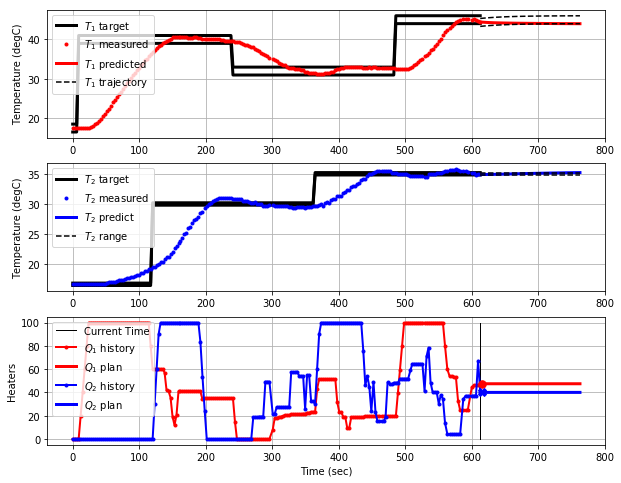

In [4]:
plt.figure(figsize=(10,8))
ax=plt.subplot(3,1,1)
ax.grid()
plt.plot(tm[0:i+1],T1sp[0:i+1]+db1,'k-',\
label=r'$T_1$ target',linewidth=3)
plt.plot(tm[0:i+1],T1sp[0:i+1]-db1,'k-',\
        label=None,linewidth=3)
plt.plot(tm[0:i+1],T1m[0:i+1],'r.',label=r'$T_1$ measured')
plt.plot(tm[i]+m.time,results['tc1.bcv'],'r-',\
        label=r'$T_1$ predicted',linewidth=3)
plt.plot(tm[i]+m.time,results['tc1.tr_hi'],'k--',\
        label=r'$T_1$ trajectory')
plt.plot(tm[i]+m.time,results['tc1.tr_lo'],'k--')
plt.ylabel('Temperature (degC)')
plt.legend(loc=2)
ax=plt.subplot(3,1,2)
ax.grid()
plt.plot(tm[0:i+1],T2sp[0:i+1]+db2,'k-',\
        label=r'$T_2$ target',linewidth=3)
plt.plot(tm[0:i+1],T2sp[0:i+1]-db2,'k-',\
        label=None,linewidth=3)
plt.plot(tm[0:i+1],T2m[0:i+1],'b.',label=r'$T_2$ measured')
plt.plot(tm[i]+m.time,results['tc2.bcv'],'b-',\
        label=r'$T_2$ predict',linewidth=3)
plt.plot(tm[i]+m.time,results['tc2.tr_hi'],'k--',\
        label=r'$T_2$ range')
plt.plot(tm[i]+m.time,results['tc2.tr_lo'],'k--')
plt.ylabel('Temperature (degC)')
plt.legend(loc=2)
ax=plt.subplot(3,1,3)
ax.grid()
plt.plot([tm[i],tm[i]],[0,100],'k-',\
        label='Current Time',linewidth=1)
plt.plot(tm[0:i+1],Q1s[0:i+1],'r.-',\
        label=r'$Q_1$ history',linewidth=2)
plt.plot(tm[i]+m.time,Q1.value,'r-',\
        label=r'$Q_1$ plan',linewidth=3)
plt.plot(tm[0:i+1],Q2s[0:i+1],'b.-',\
        label=r'$Q_2$ history',linewidth=2)
plt.plot(tm[i]+m.time,Q2.value,'b-',
        label=r'$Q_2$ plan',linewidth=3)
plt.plot(tm[i]+m.time[1],Q1.value[1],color='red',\
        marker='.',markersize=15)
plt.plot(tm[i]+m.time[1],Q2.value[1],color='blue',\
        marker='X',markersize=8)
plt.ylabel('Heaters')
plt.xlabel('Time (sec)')
plt.legend(loc=2)

In [6]:
#Calculating IAE
IAE1_gekko=np.sum(T1m-T1sp)
IAE2_gekko=np.sum(T2m-T2sp)
print("IAE for System 1={}".format(IAE1_gekko))
print("IAE for System 2={}".format(IAE2_gekko))


IAE for System 1=-670.212
IAE for System 2=-235.664


### Decoupled PID from Lab 9

Text(0.5, 0, 'Time (sec)')

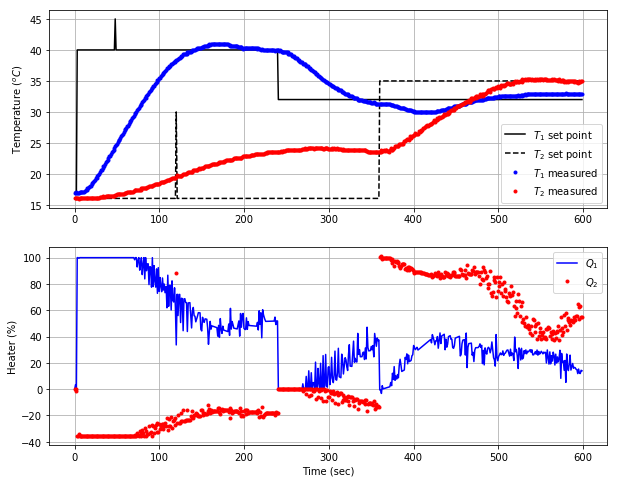

In [13]:
plt.figure(figsize=(10,8))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(tm[0:i],Tsp1[0:i],'k',label=r'$T_1$ set point')
plt.plot(tm[0:i],Tsp2[0:i],'k--',label=r'$T_2$ set point')
plt.plot(tm[0:i],T1[0:i],'b.',label=r'$T_1$ measured')
plt.plot(tm[0:i],T2[0:i],'r.',label=r'$T_2$ measured')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc=4)
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
plt.plot(tm[0:i],Q2[0:i],'r.',label=r'$Q_2$')
plt.ylabel('Heater (%)')
plt.legend(loc=1)
plt.xlabel('Time (sec)')

In [ ]:
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# PID Parameters
#Kc   = 4.67
#tauI = 47.38# sec
#tauD = 2.0   # sec
#Kff  = -0.039
params1=[11.76,45.66,7.05,0]
params2=[37.25,24.69,0.05,0]# sec

#decoupling parameter
Tdecoup=0.252/0.710
#-----------------------------------------
# PID Controller
#-----------------------------------------
# inputs ---------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs --------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,D_last,ierr,dt,d,params):
    # Parameters in terms of PID coefficients
    Kc=params[0]
    tauI=params[1]
    tauD=params[2]
    Kff=params[3]
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    # calculate the error
    error = sp-pv
    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

# save txt file with data and set point
# t = time
# u1,u2 = heaters
# y1,y2 = tempeatures
# sp1,sp2 = setpoints
def save_txt(t, u1, u2, y1, y2, sp1, sp2):
    data = np.vstack((t, u1, u2, y1, y2, sp1, sp2))  # vertical stack
    data = data.T  # transpose data
    top = ('Time,Q1,Q2,T1,T2,TSP1,TSP2')
    np.savetxt('validate.txt', data, delimiter=',',\
               header=top, comments='')

# Connect to Arduino
a = tclab.TCLab()

# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 10.0

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature
# set point (degC)
Tsp1 = np.ones(loops) * a.T1
Tsp2 = np.ones(loops) * a.T2 
# Heater set point steps
#multiplying set point times by 3 sec in order to match MPC code
Tsp1[3:]=40.0
Tsp2[120]=30.0
Tsp1[240:]=32.0
Tsp2[360:]=35.0
Tsp1[48] = 45.0


T1 = np.ones(loops) * a.T1 # measured T (degC)
error_sp1 = np.zeros(loops)
error_sp2 = np.zeros(loops)
# set point (degC)
T2 = np.ones(loops) * a.T2 # measured T (degC)

# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q2 = np.ones(loops) * 0.0
D1 = np.ones(loops) * 0.0
D2 = np.ones(loops) * 0.0
print('Running Main Loop. Ctrl-C to end.')
print('  Time     SP     PV     Q1   =  P   +  I  +   D    IAE')
print(('{:6.1f} {:6.2f} {:6.2f} ' + \
       '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
           tm[0],Tsp1[0],T1[0], \
           Q1[0],0.0,0.0,0.0,0.0))

# Main Loop
start_time = time.time()
prev_time = start_time
dt_error = 0.0
# Integral error
ierr1 = 0.0
ierr2=0.0
# Integral absolute error
iae1 = 0.0
iae2=0.0

plt.figure(figsize=(10,7))
plt.ion()
plt.show()

try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time) - dt_error
        if sleep>=1e-4:
            time.sleep(sleep-1e-4)
        else:
            print('exceeded max cycle time by ' + str(abs(sleep)) + ' sec')
            time.sleep(1e-4)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        if (sleep>=1e-4):
            dt_error = dt-1.0+0.009
        else:
            dt_error = 0.0
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin
        T1[i] = a.T1
        T2[i] = a.T2
        # Disturbances
        d1 = T1[i] - 23.0
        d2 = T2[i] - 23.0

        # Integral absolute error
        iae1 += np.abs(Tsp1[i]-T1[i])
        iae2 += np.abs(Tsp2[i]-T2[i])

        # Calculate PID output
        [Q1[i],P1,ierr1,D1[i]] = pid(Tsp1[i],T1[i],T1[i-1],D1[i],ierr1,dt,d1,params1)
        [Q2[i],P2,ierr2,D2[i]] = pid(Tsp2[i],T2[i],T2[i-1],D2[i],ierr2,dt,d2,params2)
        
        Q1[i]=Q1[i]-Tdecoup*Q2[i]
        Q2[i]=Q2[i]-Tdecoup*Q1[i]

        # Write output (0-100)
        a.Q1(Q1[i])
        a.Q2(Q2[i])

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P1,ierr1,D1[i],iae1))

        # Update plot
        plt.clf()
        # Plot
        ax=plt.subplot(2,1,1)
        ax.grid()
        plt.plot(tm[0:i],Tsp1[0:i],'k-',label=r'$T_1$ set point')
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.ylabel(r'Temperature ($^oC$)')
        plt.legend(loc=4)
        ax=plt.subplot(2,1,2)
        ax.grid()
        plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
        plt.ylabel('Heater (%)')
        plt.legend(loc=1)
        plt.xlabel('Time (sec)')
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    a.close()
    # Save text file
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    # Save figure
    plt.savefig('PID_Control.png')

# Allow user to end loop with Ctrl-C          
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('PID_Control.png')

# Make sure serial connection closes with an error
except:          
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('PID_Control.png')
    raise

In [15]:
IAE1_decoupled=np.sum(T1-Tsp1)
IAE2_decoupled=np.sum(T2-Tsp2)
print("IAE for System 1={}".format(IAE1_decoupled))
print("IAE for System 2={}".format(IAE2_decoupled))


IAE for System 1=-1186.338
IAE for System 2=879.0279999999999


### Comparison of Results

For both systems, we see that the magnitude of the IAE is greater for the de-coupled PID control compared to the MPC controller. This is expected because the PID has many fluctuations and is not as good as supressing disturbances. Additionally, we see the Q2 heater values for the de-coupled IMC continuously break and re-continue. This was not the case with the MPC. The MPC had straight and continuous shifts in set point as desired and the magnitude of the set point and temperature values were a lot smaller.

# Exercise 2

Set the T1 setpoint to a sinusoidal curve while maintaining a constant T2 temperature and re-run the experiment. Compare to your results from last time with the decoupled PID controller. Quantify the results using the IAE.

In [ ]:
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# PID Parameters
#Kc   = 4.67
#tauI = 47.38# sec
#tauD = 2.0   # sec
#Kff  = -0.039
params1=[11.76,45.66,7.05,0]
params2=[37.25,24.69,0.05,0]# sec

#decoupling parameter
Tdecoup=-0.252/0.710
#-----------------------------------------
# PID Controller
#-----------------------------------------
# inputs ---------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs --------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,D_last,ierr,dt,d,params):
    # Parameters in terms of PID coefficients
    Kc=params[0]
    tauI=params[1]
    tauD=params[2]
    Kff=params[3]
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    # calculate the error
    error = sp-pv
    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

# save txt file with data and set point
# t = time
# u1,u2 = heaters
# y1,y2 = tempeatures
# sp1,sp2 = setpoints
def save_txt(t, u1, u2, y1, y2, sp1, sp2):
    data = np.vstack((t, u1, u2, y1, y2, sp1, sp2))  # vertical stack
    data = data.T  # transpose data
    top = ('Time,Q1,Q2,T1,T2,TSP1,TSP2')
    np.savetxt('validate.txt', data, delimiter=',',\
               header=top, comments='')

# Connect to Arduino
a = tclab.TCLab()

# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 10.0

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)
ti=np.linspace(0,loops-1,loops)

# Temperature
# set point (degC)
Tsp1=np.ones(loops)
Tsp2=np.ones(loops)
# Heater set point steps
Tsp1[10:]=-35*np.cos(0.015*(ti[10:]-10))+23+35
#Tsp1[3:]=40.0
Tsp2[10:]=55


T1 = np.ones(loops) * a.T1 # measured T (degC)
T2 = np.ones(loops) * a.T2 # measured T (degC)
error_sp1 = np.zeros(loops)
error_sp2 = np.zeros(loops)
# set point (degC)


# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q2 = np.ones(loops) * 0.0
D1 = np.ones(loops) * 0.0
D2 = np.ones(loops) * 0.0
print('Running Main Loop. Ctrl-C to end.')
print('  Time     SP     PV     Q1   =  P   +  I  +   D    IAE')
print(('{:6.1f} {:6.2f} {:6.2f} ' + \
       '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
           tm[0],Tsp1[0],T1[0], \
           Q1[0],0.0,0.0,0.0,0.0))

# Main Loop
start_time = time.time()
prev_time = start_time
dt_error = 0.0
# Integral error
ierr1 = 0.0
ierr2=0.0
# Integral absolute error
iae1 = 0.0
iae2=0.0

plt.figure(figsize=(10,7))
plt.ion()
plt.show()

try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time) - dt_error
        if sleep>=1e-4:
            time.sleep(sleep-1e-4)
        else:
            print('exceeded max cycle time by ' + str(abs(sleep)) + ' sec')
            time.sleep(1e-4)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        if (sleep>=1e-4):
            dt_error = dt-1.0+0.009
        else:
            dt_error = 0.0
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin
        T1[i] = a.T1
        T2[i] = a.T2
        # Disturbances
        d1 = T1[i] - 23.0
        d2 = T2[i] - 23.0
    

        # Integral absolute error
        iae1 += np.abs(Tsp1[i]-T1[i])
        iae2 += np.abs(Tsp2[i]-T2[i])
  

        # Calculate PID output
        [Q1[i],P1,ierr1,D1[i]] = pid(Tsp1[i],T1[i],T1[i-1],D1[i],ierr1,dt,d1,params1)
        [Q2[i],P2,ierr2,D2[i]] = pid(Tsp2[i],T2[i],T2[i-1],D2[i],ierr2,dt,d2,params2)
        
        Q1[i]=Q1[i]-Tdecoup*Q2[i]
        Q2[i]=Q2[i]-Tdecoup*Q1[i]
        #clip output
        Q1[i]=max(0,min(100,Q1[i]))
        Q2[i]=max(0,min(100,Q2[i]))

        # Write output (0-100)
        a.Q1(Q1[i])
        a.Q2(Q2[i])

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P1,ierr1,D1[i],iae1))

        # Update plot
        plt.clf()
        # Plot
        ax=plt.subplot(2,1,1)
        ax.grid()
        plt.plot(tm[0:i],Tsp1[0:i],'k--',label=r'$T_1$ set point')
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.ylabel(r'Temperature ($^oC$)')
        plt.legend(loc=4)
        ax=plt.subplot(2,1,2)
        ax.grid()
        plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
        plt.ylabel('Heater (%)')
        plt.legend(loc=1)
        plt.xlabel('Time (sec)')
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    a.close()
    # Save text file
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    # Save figure
    plt.savefig('PID_Control.png')

# Allow user to end loop with Ctrl-C          
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('PID_Control.png')

# Make sure serial connection closes with an error
except:          
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('PID_Control.png')
    raise

Text(0.5, 0, 'Time (sec)')

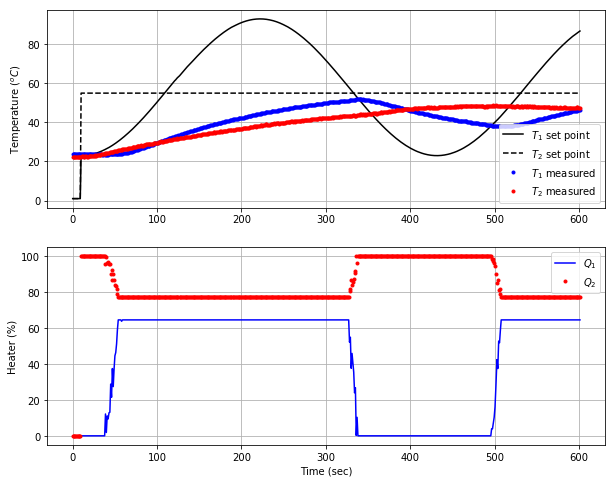

In [2]:
plt.figure(figsize=(10,8))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(tm[0:i],Tsp1[0:i],'k',label=r'$T_1$ set point')
plt.plot(tm[0:i],Tsp2[0:i],'k--',label=r'$T_2$ set point')
plt.plot(tm[0:i],T1[0:i],'b.',label=r'$T_1$ measured')
plt.plot(tm[0:i],T2[0:i],'r.',label=r'$T_2$ measured')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc=4)
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
plt.plot(tm[0:i],Q2[0:i],'r.',label=r'$Q_2$')
plt.ylabel('Heater (%)')
plt.legend(loc=1)
plt.xlabel('Time (sec)')

In [3]:
print("IAE for system 1={}".format(iae1))
print("IAE for system 2={}".format(iae2))

IAE for system 1=13539.439278373575
IAE for system 2=8943.081999999995


### Comparison of Results
Based on the calculated IAEs, we can see that the magnitude of the decoupled IAE with a sinusoidal T1 set point and constant T2 set point is significantly higher than the other two methods. The heater values oscillate more continuously compared to the decoupled PID case (non-sinusoidal), however the deviation from set point is much higher compared to the MPC case. This is what is expected because of the addition of the sinusoidal term. The addition of the sinusoidal term makes it increasingly difficult for the T1 temperature to attain setpoint in very short periods of time and that's why we observe a singificantly higher IAE for system 1.